In [48]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
import scipy

import sys
sys.path.insert(1, 'strf-like-model')

%matplotlib notebook

def sinusoid(f0, duration, sr):
    t = np.arange(0, duration, 1/sr)
    return np.sin(2 * np.pi * f0 * t)


def generate(f_c, f_m, gamma, bw, duration=2, sr=2**14):
    t = np.arange(-duration/2, duration/2, 1/sr)
    chirp_phase = 2*np.pi*f_c / (gamma*np.log(2)) * (2 ** (gamma*t) - 1)
    carrier = np.sin(chirp_phase)
    modulator = np.sin(2 * np.pi * f_m * t)
    window_std = bw*sr / (gamma*duration)
    window = scipy.signal.gaussian(duration*sr, std=window_std)
    x = carrier * modulator * window
    return x

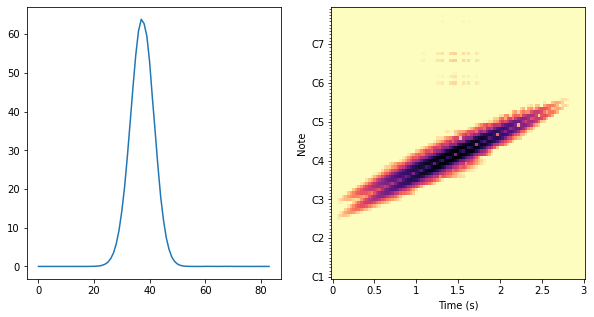

In [99]:
from IPython.display import Audio, display

from librosa.display import specshow

%matplotlib inline
f_c = 300
f_m = 16
gamma = 1
bw = 1
duration = 3
sr = 2**14

x = generate(f_c, f_m, gamma, bw, duration, sr)
C = np.abs(librosa.cqt(x, sr=sr))
t = np.arange(-duration/2, duration/2, 1/sr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.sum(C, axis=1))
plt.subplot(1, 2, 2)
specshow(librosa.amplitude_to_db(C), sr=sr, x_axis="time", y_axis="cqt_note", cmap="magma_r")
plt.xlabel("Time (s)")
display(Audio(x, rate=2**14))

In [2]:
f0s = np.logspace(np.log10(100), np.log10(200), 16)
fms = np.logspace(np.log10(4), np.log10(32), 16)
gammas = np.logspace(np.log10(0.5), np.log10(4), 16)

duration, sr = 1, 2**13
f0 = f0s[10]
fm = fms[10]
gamma = gammas[10]

audio = generate(f0, fm, gamma, sr=sr, duration=duration)

In [3]:
import os
os.system("pip install tqdm")

0

In [4]:
import auditory
import tqdm

audio = np.zeros((len(f0s), len(fms), len(gammas), duration * sr))
cmap = np.zeros((3, len(f0s) * len(fms) * len(gammas)))
c = 0
for i, f0 in tqdm.tqdm(enumerate(f0s)):
    for j, fm in enumerate(fms):
        for k, gamma in enumerate(gammas):
            audio[i, j, k] = generate(f0, fm, gamma, sr=sr, duration=duration)
            cmap[0, c], cmap[1, c], cmap[2, c] = f0, fm, gamma
            c += 1


16it [00:01,  9.18it/s]


In [5]:
X = audio.reshape((-1, audio.shape[-1]))

In [7]:
n_samples = X.shape[0]
S = auditory.strf(X[0, :], audio_fs=sr, duration=1)
S = np.concatenate((
    S[0].reshape((S[0].shape[0], S[0].shape[1], -1)),
    S[1][:, :, np.newaxis]),
    axis=-1).mean(axis=0)
n_freqs, n_paths = S.shape
sx = np.zeros((n_samples, n_freqs, n_paths))

for i in tqdm.tqdm(range(n_samples)):
    S = auditory.strf(X[i], audio_fs=sr, duration=1)
    S = np.concatenate((
        S[0].reshape((S[0].shape[0], S[0].shape[1], -1)),
        S[1][:, :, np.newaxis]),
        axis=-1).mean(axis=0)
    sx[i, :] = S

  0%|                                                                 | 0/4096 [00:00<?, ?it/s]/var/folders/fv/kkm71l3d1rx_kjd66cmfpg8r0000gp/T/ipykernel_7542/4084917156.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  sx[i, :] = S
100%|██████████████████████████████████████████████████████| 4096/4096 [48:19<00:00,  1.41it/s]


(4096, 128, 177)

In [14]:
os.makedirs("/Users/user/kymatio-jtfs/data/strf", exist_ok=True)

for i in tqdm.tqdm(range(sx.shape[0])):
    np.save(f'/Users/user/kymatio-jtfs/data/strf/{i}', sx[i])

100%|████████████████████████████████████████████████████| 4096/4096 [00:04<00:00, 1020.79it/s]


In [19]:
def plot_isomap(Y, cmap):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[0], cmap='bwr');
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # f modulator
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[1], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # chirp rate
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[2], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

In [25]:
from sklearn.manifold import Isomap



embedding = Isomap(n_components=3, n_neighbors=40)
Y = embedding.fit_transform(sx.reshape((sx.shape[0], -1)))
plot_isomap(Y, cmap)

<IPython.core.display.Javascript object>


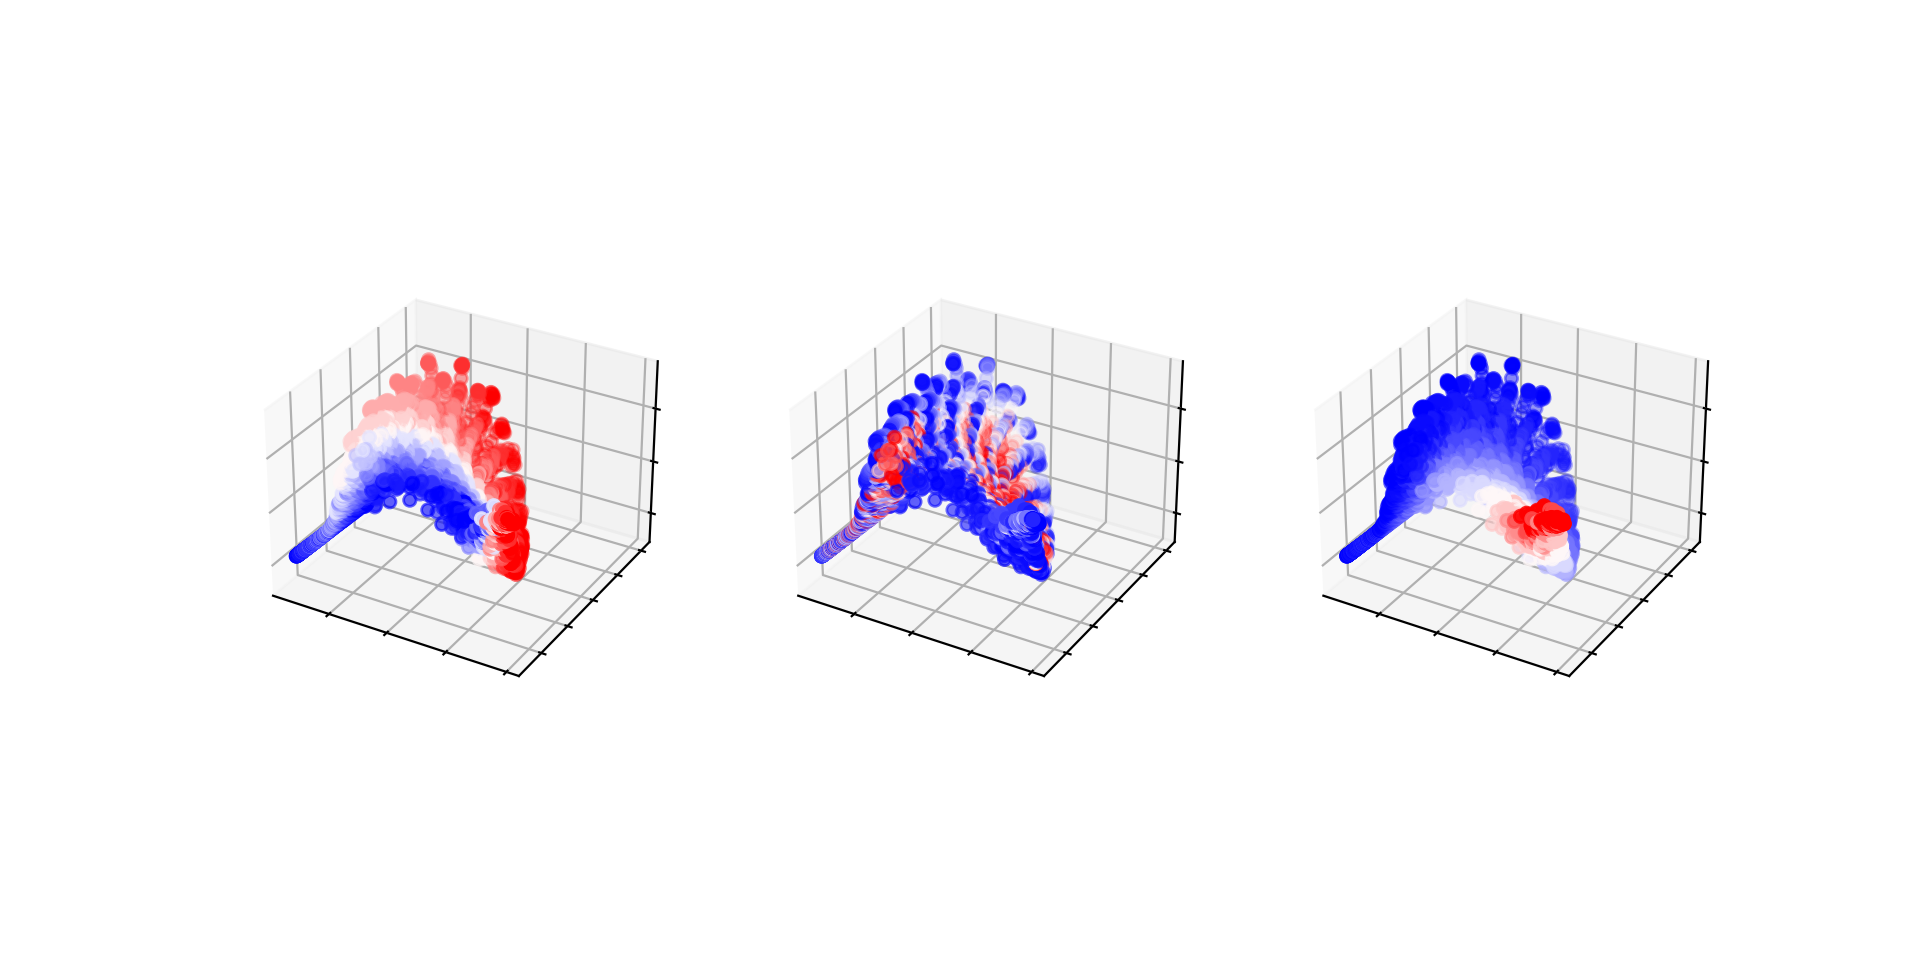

In [26]:
plot_isomap(Y, cmap)